## Sarcasm_Headlines

In [298]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import collections
from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\benit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [299]:
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
df['headline'][9]
#df.head()

'lots of parents know this scenario'

In [300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [301]:
df.drop_duplicates(inplace=True)
df.isna().any()

is_sarcastic    False
headline        False
article_link    False
dtype: bool

In [302]:
df["is_sarcastic"].value_counts()

0    14984
1    13633
Name: is_sarcastic, dtype: int64

# Remove Stopwords

In [303]:
stop = stopwords.words('english')
df['headline'] = df['headline'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) #CHTGPT

In [304]:
df['headline'][9]

'lots parents know scenario'

# Stemming

In [305]:
ps = PorterStemmer()
df['headline'] = df['headline'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))

# Lemmetaization

In [306]:
#Lemmetaization of df['headline']
lemmatizer = WordNetLemmatizer()
df['headline'] = df['headline'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Data Exploration

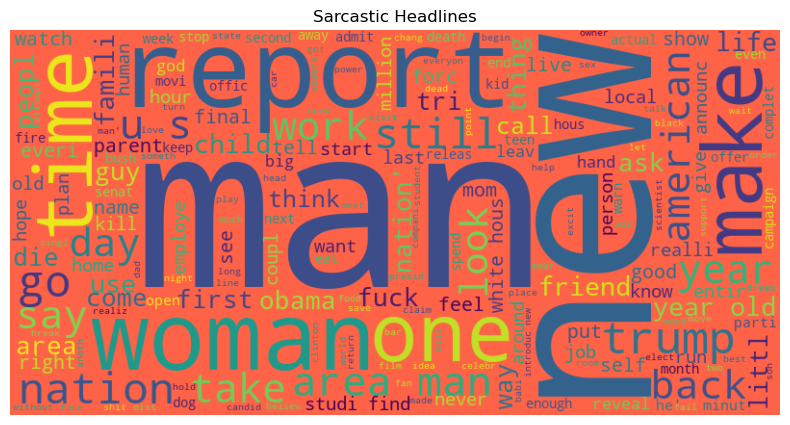

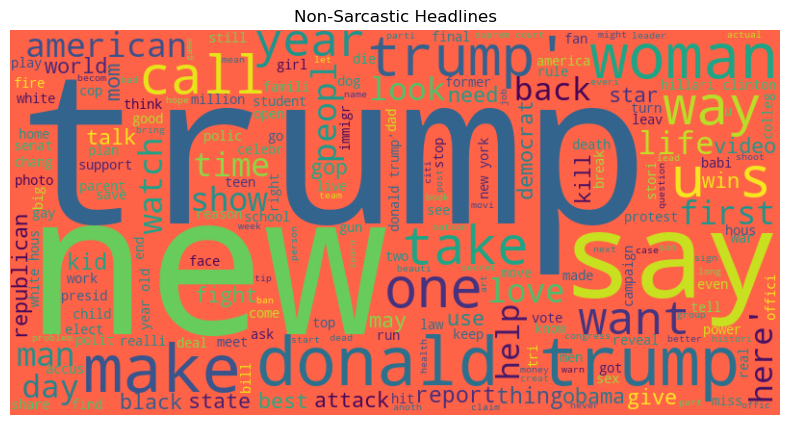

In [307]:
#CHTGPT
df_sarcastic = df[df['is_sarcastic'] == 1]
df_not_sarcastic = df[df['is_sarcastic'] == 0]

# Create a function to generate a word cloud plot
def plot_wordcloud(df_subset, title):
    # Concatenate all the headlines into a single string
    text = " ".join(headline for headline in df_subset['headline'])

    # Generate a word cloud object
    wordcloud = WordCloud(width=800, height=400, max_words=200, background_color="tomato").generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.savefig('plots/'+ title + '.png')
    plt.show()

# Generate the word cloud plot for sarcastic headlines
plot_wordcloud(df_sarcastic, "Sarcastic Headlines")

# Generate the word cloud plot for non-sarcastic headlines
plot_wordcloud(df_not_sarcastic, "Non-Sarcastic Headlines")


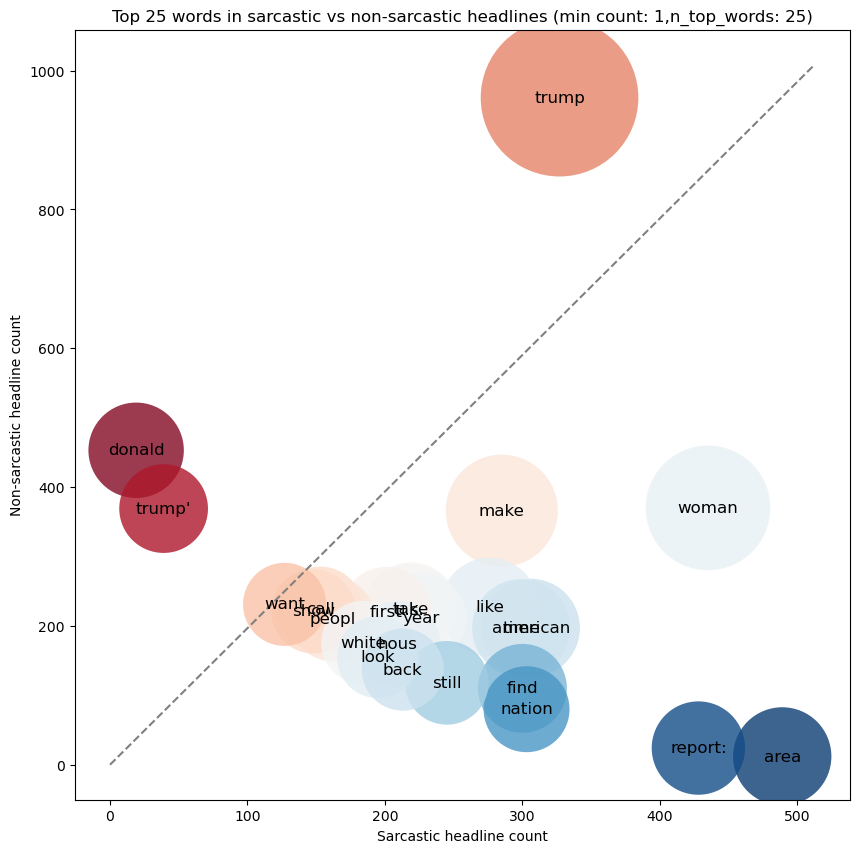

In [308]:
#CHGTPT
min_count = 1
n_top_words = 25

# Count the frequency of each word in sarcastic and non-sarcastic headlines
word_counts = {}
for index, row in df.iterrows():
    for word in row['headline'].split():
        if len(word) > 3:
            if word not in word_counts:
                word_counts[word] = {
                    'count_sarcastic': 0,
                    'count_non_sarcastic': 0,
                    'count_total': 0
                }
            word_counts[word]['count_total'] += 1
            if row['is_sarcastic'] == 1:
                word_counts[word]['count_sarcastic'] += 1
            else:
                word_counts[word]['count_non_sarcastic'] += 1

# Convert the word counts to a DataFrame
df_words = pd.DataFrame.from_dict(word_counts, orient='index')
df_words = df_words[df_words['count_total'] >= min_count]

# Sort the DataFrame by total count
df_words = df_words.sort_values('count_total', ascending=False)

# Select the top n words

df_words = df_words.nlargest(n_top_words, 'count_total')

# Compute the proportion of sarcastic headlines for each word
df_words['prop_sarcastic'] = df_words['count_sarcastic'] / df_words['count_total']

# Define the color map
cmap = cm.get_cmap('RdBu')
colors = cmap(df_words['prop_sarcastic'])

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(
    x=df_words['count_sarcastic'], 
    y=df_words['count_non_sarcastic'], 
    s=df_words['count_total']*10,
    alpha=0.8,
    edgecolors='none',
    c=colors
)

# Add a 45-degree line starting from (0,0)
ax.plot([0, ax.get_xlim()[1]], [0, ax.get_ylim()[1]], ls='--', color='gray')

for index, row in df_words.iterrows():
    ax.annotate(row.name, 
                (row['count_sarcastic'], row['count_non_sarcastic']), 
                fontsize=12, 
                ha='center', 
                va='center')

ax.set_xlabel('Sarcastic headline count')
ax.set_ylabel('Non-sarcastic headline count')

ax.set_title(f'Top {n_top_words} words in sarcastic vs non-sarcastic headlines (min count: {min_count},n_top_words: {n_top_words})')

plt.savefig('plots/word_bubbles.png', dpi=300)
plt.show()



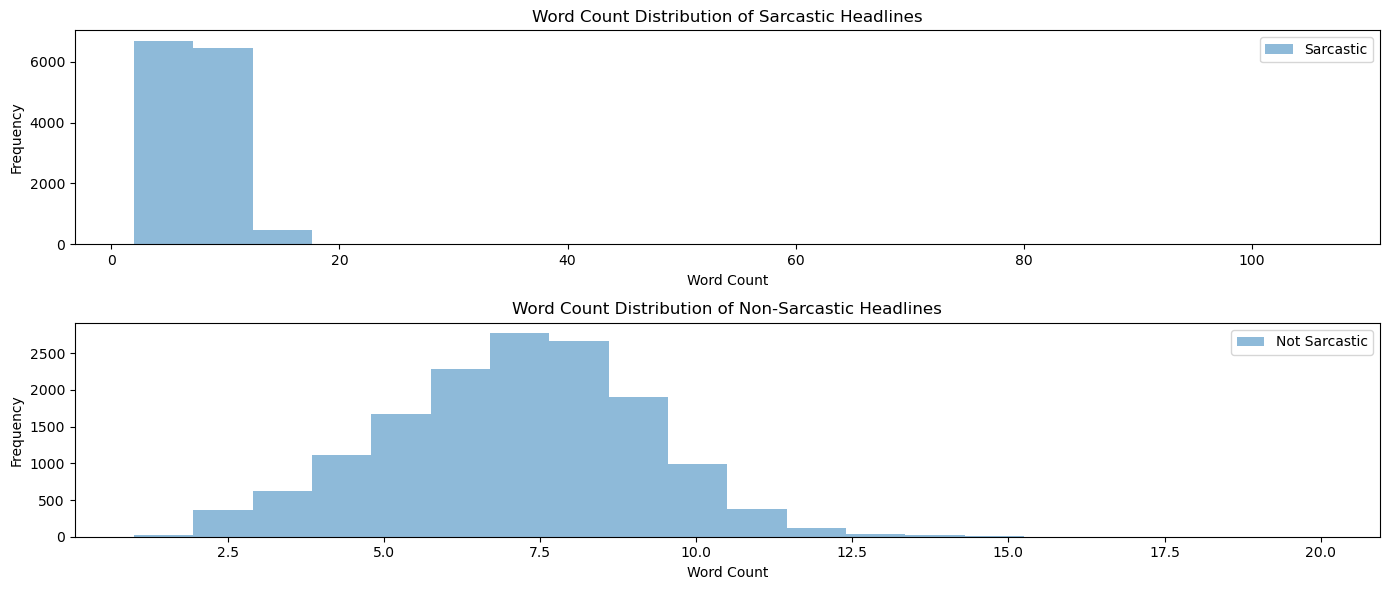

In [309]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 6))
ax[0].hist(df[df['is_sarcastic']==1]['headline'].apply(lambda x: len(x.split())), bins=20, alpha=0.5, label='Sarcastic')
ax[1].hist(df[df['is_sarcastic']==0]['headline'].apply(lambda x: len(x.split())), bins=20, alpha=0.5, label='Not Sarcastic')
ax[0].set_title('Word Count Distribution of Sarcastic Headlines')
ax[1].set_title('Word Count Distribution of Non-Sarcastic Headlines')
ax[0].set_xlabel('Word Count')
ax[1].set_xlabel('Word Count')
ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('Frequency')
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.savefig('plots/word_count_hist_1.png', dpi=300)
plt.show()

In [310]:
max_words = 100000
max_seq = 100000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['headline'].values)
sequences = tokenizer.texts_to_sequences(df['headline'].values)

In [311]:
#help from CHTGPT
padded_sequences = pad_sequences(sequences, maxlen=max_seq)


In [312]:


# Create tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['headline'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['headline'])


# find maxmimum number of words in a headline
maxlen = max([len(x) for x in sequences])
padded_sequences = pad_sequences(sequences, maxlen=maxlen)
print(padded_sequences.shape)
print(padded_sequences[5])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['is_sarcastic'], test_size=0.2, random_state=187,stratify=df['is_sarcastic'])
#validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=187,stratify=y_train)

model = Sequential()
model.add(Embedding(max_words, 32, input_length=maxlen))

model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.2))
model.add(Dense(32, activation='relu6'))

model.add(Dense(1, activation='sigmoid'))


early_stop = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

#print all option for metric in model.compile
print(model.metrics_names)


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Accuracy','Recall'])

model.summary()


# Train the model
history= model.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_val, y_val),callbacks=[early_stop])

(28617, 107)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0   34 6072]
[]
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_59 (Embedding)    (None, 107, 32)           3200000   
                                                                 
 lstm_59 (LSTM)              (None, 64)                24832     
                                                                 
 dense_81 (Dense)    

KeyboardInterrupt: 

In [ ]:
train_loss = model.evaluate(X_train, y_train)
val_loss = model.evaluate(X_val, y_val)
test_loss = model.evaluate(X_test, y_test)
print("Train set loss: ",(train_loss))
print("Validation set loss:",(val_loss))
print("Test set loss: ",(test_loss))

179/179 [==============================] - 4s 23ms/step - loss: 0.4478 - Accuracy: 0.7851 - recall: 0.7884
Train set loss:  [0.28101471066474915, 0.8987659811973572, 0.9119770526885986]
Validation set loss: [0.44047102332115173, 0.7977724671363831, 0.8129298686981201]
Test set loss:  [0.4478031396865845, 0.7851153016090393, 0.7884121537208557]


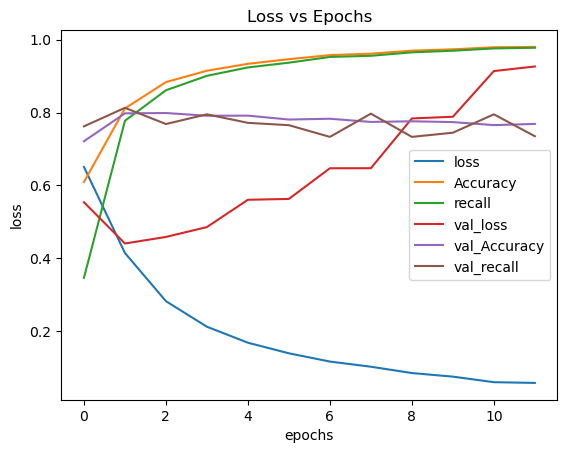

In [ ]:
pd.DataFrame(history.history).plot()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('Loss vs Epochs')
plt.savefig('plots/loss.png', dpi=300)
plt.show()

179/179 [==============================] - 4s 24ms/step


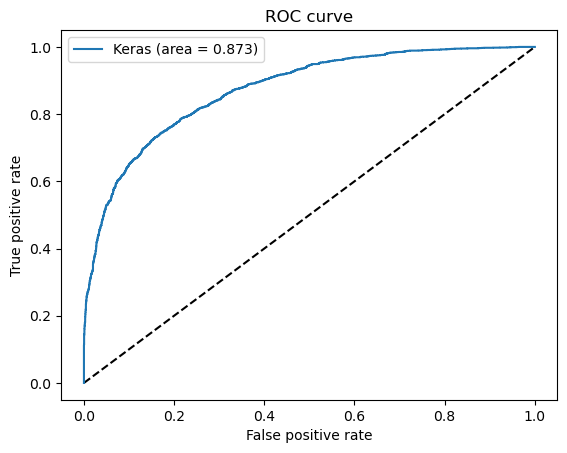

In [ ]:

from sklearn.metrics import roc_curve, auc

#plot ROC Kurve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('plots/ROC.png', dpi=300)
plt.show()


179/179 [==============================] - 4s 22ms/step
[[2344  653]
 [ 577 2150]]


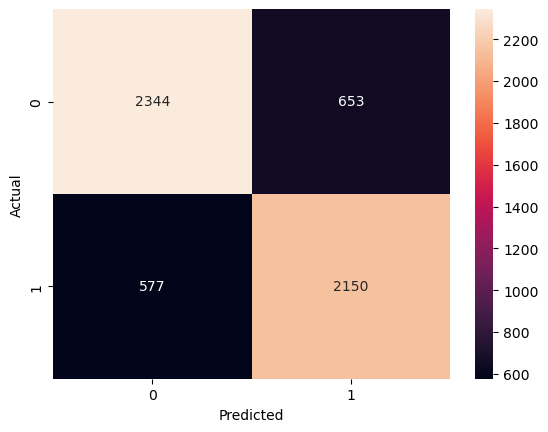

In [ ]:
#confusion matrix with test_sets and matplotlib
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('plots/confusion_matrix.png', dpi=300)
plt.show()




In [316]:
from sklearn.metrics import classification_report
target_names = ['non-sarcastic', 'sarcastic']
print(classification_report(y_test, y_pred, target_names=target_names))



               precision    recall  f1-score   support

non-sarcastic       0.80      0.78      0.79      2997
    sarcastic       0.77      0.79      0.78      2727

     accuracy                           0.79      5724
    macro avg       0.78      0.79      0.78      5724
 weighted avg       0.79      0.79      0.79      5724



In [315]:
# build the lightgbm model
import lightgbm as lgb
clf = lgb.LGBMClassifier(class_weight='balanced', metrics='recall')
clf.fit(X_train, y_train)
y_pred_lgbm=clf.predict(X_test)

accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_lgbm)))
y_pred_train = clf.predict(X_train)
y_pred_train = clf.predict(X_train)
print(classification_report(y_test, y_pred_lgbm, target_names=target_names))

LightGBM Model accuracy score: 0.6317
               precision    recall  f1-score   support

non-sarcastic       0.64      0.68      0.66      2997
    sarcasric       0.62      0.57      0.60      2727

     accuracy                           0.63      5724
    macro avg       0.63      0.63      0.63      5724
 weighted avg       0.63      0.63      0.63      5724

